In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
% matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import graphviz

In [191]:
# import data
train = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')

In [90]:
print('training data contains', len(train), 'and test data', len(test))
print('there are', len(train.columns), 'columns')
print('there are', len(train[train['IsBadBuy']==1])/len(train)*100, 'percent kicks')

training data contains 72983 and test data 48707
there are 34 columns
there are 12.298754504473644 percent kicks


# Data Exploration and Cleaning

In [130]:
train.head().transpose()

,0,1,2,3,4
RefId,1,2,3,4,5
IsBadBuy,0,0,0,0,0
PurchDate,12/7/2009,12/7/2009,12/7/2009,12/7/2009,12/7/2009
Auction,ADESA,ADESA,ADESA,ADESA,ADESA
VehYear,2006,2004,2005,2004,2005
VehicleAge,3,5,4,5,4
Make,MAZDA,DODGE,DODGE,DODGE,FORD
Model,MAZDA3,1500 RAM PICKUP 2WD,STRATUS V6,NEON,FOCUS
Trim,i,ST,SXT,SXT,ZX3
SubModel,4D SEDAN I,QUAD CAB 4.7L SLT,4D SEDAN SXT FFV,4D SEDAN,2D COUPE ZX3


In [214]:
# convert date
train['PurchDate'] = pd.to_datetime(train['PurchDate'])
test['PurchDate'] = pd.to_datetime(test['PurchDate'])
print(train['PurchDate'].dtype)

# fix var name
train.rename(columns={'MMRAcquisitonRetailCleanPrice': 'MMRAcquisitionRetailCleanPrice'}, inplace=True)
test.rename(columns={'MMRAcquisitonRetailCleanPrice': 'MMRAcquisitionRetailCleanPrice'}, inplace=True)

datetime64[ns]


In [215]:
# convert categorical columns
cate_cols = ['Auction', 'Make', 'Model', 'Trim', 'SubModel', 'Transmission', 'WheelTypeID', 'WheelType', 'Nationality', 'Size', 'TopThreeAmericanName', 'PRIMEUNIT', 'AUCGUART']
for col in cate_cols:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

cols_to_drop = ['RefId', 'Color', 'BYRNO', 'VNZIP1', 'VNST', 'VehYear']
train.drop(cols_to_drop, axis=1, inplace=True)
cols_to_drop.remove('RefId')
test.drop(cols_to_drop, axis=1, inplace=True)

In [216]:
# add relevant features
# acquisition cost at the time of purchase - CONVERT to percentages to cost at time of purchase
cols_to_convert = ['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', \
                     'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitionRetailCleanPrice']
for col in cols_to_convert:
    train[col+'_diff'] = train[col] / train['VehBCost'] - 1
    test[col+'_diff'] = test[col] / test['VehBCost'] - 1

In [217]:
# current day MMR prices depend on the date of auction
# convert to depreciation percentage per year since auction date
current_cols = ['MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', \
                'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice']
for col in current_cols:
    compare_to = col.replace('Current', 'Acquisition')
    train[col+'_DepPerYear'] = (train[compare_to] - train[col]) / train[compare_to]
    # assume current day in 6 years ago (when data was published) - Sept 2011
    train[col+'_DepPerYear'] /= (pd.to_datetime('09/01/2011') - train['PurchDate']).dt.days / 365
    mean = train[train[col+'_DepPerYear'] != float('-inf')][col+'_DepPerYear'].mean()
    train[col+'_DepPerYear'].replace(float('-inf'), mean, inplace=True)
    
    # apply to test
    test[col+'_DepPerYear'] = (test[compare_to] - test[col]) / test[compare_to]
    test[col+'_DepPerYear'] /= (pd.to_datetime('09/01/2011') - test['PurchDate']).dt.days / 365
    mean = test[test[col+'_DepPerYear'] != float('-inf')][col+'_DepPerYear'].mean()
    test[col+'_DepPerYear'].replace(float('-inf'), mean, inplace=True)

In [218]:
# remove original cols
for col in cols_to_convert+current_cols:
    del train[col]
    del test[col]

# remove auction date after use
del train['PurchDate']
del test['PurchDate']

# get non categorical cols
noncate_cols = list(set(train.columns.tolist()) - set(cate_cols))
noncate_cols

['IsOnlineSale',
 'WarrantyCost',
 'MMRCurrentAuctionAveragePrice_DepPerYear',
 'MMRAcquisitionRetailCleanPrice_diff',
 'MMRAcquisitionAuctionCleanPrice_diff',
 'VehBCost',
 'MMRCurrentRetailCleanPrice_DepPerYear',
 'VehicleAge',
 'MMRAcquisitionAuctionAveragePrice_diff',
 'MMRCurrentRetailAveragePrice_DepPerYear',
 'MMRAcquisitionRetailAveragePrice_diff',
 'MMRCurrentAuctionCleanPrice_DepPerYear',
 'IsBadBuy',
 'VehOdo']

In [219]:
# find vars with null values
# so that we can fill them
na_test = train.isnull().any()
na_cols = na_test[na_test == True].index

def fillna(df, col_list):
    for col in col_list:
        if df[col].dtype.name == 'category':
            # fill with majority
            majority = df[col].mode()[0]
            print('Filling', col, 'with', majority, '...')
            df[col].fillna(value=majority, inplace=True)
        else:
            # fill with mean
            mean = df[col].mean()
            print('Filling', col, 'with', mean, '...')
            df[col].fillna(value=df[col].mean(), inplace=True)

fillna(train, na_cols.tolist())
fillna(test, na_cols.tolist())

Filling Trim with Bas ...
Filling SubModel with 4D SEDAN ...
Filling Transmission with AUTO ...
Filling WheelTypeID with 1.0 ...
Filling WheelType with Alloy ...
Filling Nationality with AMERICAN ...
Filling Size with MEDIUM ...
Filling TopThreeAmericanName with GM ...
Filling PRIMEUNIT with NO ...
Filling AUCGUART with GREEN ...
Filling MMRAcquisitionAuctionAveragePrice_diff with -0.07100732003152618 ...
Filling MMRAcquisitionAuctionCleanPrice_diff with 0.13468529867638662 ...
Filling MMRAcquisitionRetailAveragePrice_diff with 0.29843173050521127 ...
Filling MMRAcquisitionRetailCleanPrice_diff with 0.523433029471883 ...
Filling MMRCurrentAuctionAveragePrice_DepPerYear with 0.00016995622050984416 ...
Filling MMRCurrentAuctionCleanPrice_DepPerYear with -0.5140252873989734 ...
Filling MMRCurrentRetailAveragePrice_DepPerYear with -0.020022053382521544 ...
Filling MMRCurrentRetailCleanPrice_DepPerYear with -0.017619585525653896 ...
Filling Trim with Bas ...
Filling SubModel with 4D SEDAN .

In [220]:
dummy_df = pd.get_dummies(train[cate_cols])
dummy_cols = set(dummy_df.columns.tolist())

In [221]:
test_dummy_df = pd.get_dummies(test[cate_cols])
test_dummy_cols = set(test_dummy_df.columns.tolist())
union_dummy_cols = test_dummy_cols & dummy_cols
additional_dummy_cols = dummy_cols - test_dummy_cols

test = pd.concat([test, test_dummy_df[list(union_dummy_cols)]], axis=1)

In [222]:
print('There are', len(additional_dummy_cols), 'dummy columns that did not appear in test data')
print('adding columns filled with zero...')
for col in list(additional_dummy_cols):
    test[col] = pd.Series(np.zeros(len(test)))

There are 356 dummy columns that did not appear in test data
adding columns filled with zero...


In [223]:
train = pd.concat([train, dummy_df], axis=1)
train.drop(cate_cols, axis=1, inplace=True)

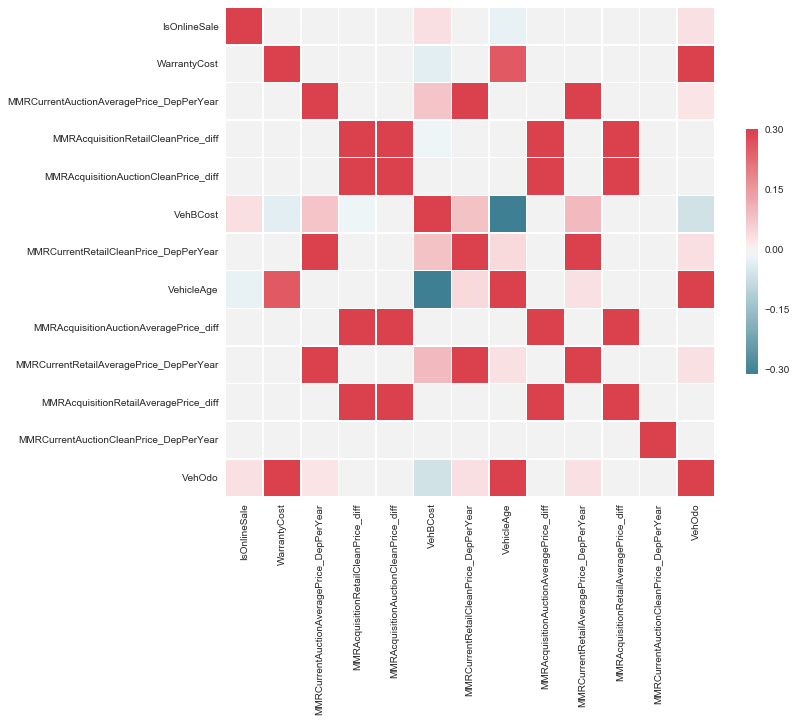

In [142]:
sns.set(style="white")


# Compute the correlation matrix
# ONLY for non-categorical variables
corr = train[list(noncate_cols)].corr()
f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

#### From the correlation matrix above, we can see that "IsBadBuy" is highly correlated with "VehBCost", "VehicleAge", "VehOdo" and "WarrantyCost". It is also somewhat correlated with "CurrentAveragePrice_DepPerYear" and "CurrentRetailPrice_DepPerYear". These variables all make a lot of sense for identifying a kick.

Note: The above plot does not include categorical turned dummy variables, since there are over 2000 of them.

# Modeling

In [130]:
target = 'IsBadBuy'
noncate_cols.remove(target)

In [57]:
# start with the simpliest model
# logistic regression

# noncate features
model = LogisticRegression()
scores = cross_val_score(model, train[noncate_cols], train[target], cv=5)
print('Average validation score is', sum(scores)/5, 'with', len(noncate_cols), 'features')

# with all features
features = train.columns.tolist()
features.remove(target)
model = LogisticRegression()
scores = cross_val_score(model, train[features], train[target], cv=5)
print('Average validation score is', sum(scores)/5, 'with', len(features), 'features')

Average validation score is 0.8770124558999403 with 13 features
Average validation score is 0.8770124558999403 with 2143 features


In [66]:
# Naive bayes
model = GaussianNB()

def evaluate(model):
    # noncate features
    scores = cross_val_score(model, train[noncate_cols], train[target], cv=5)
    print('Average validation score is', sum(scores)/5, 'with', len(noncate_cols), 'features')

    # all features
    features = train.columns.tolist()
    features.remove(target)
    scores = cross_val_score(model, train[features], train[target], cv=5)
    print('Average validation score is', sum(scores)/5, 'with', len(features), 'features')

evaluate(model)

In [143]:
# random forest
model = RandomForestClassifier(max_depth=10, n_estimators=100)

evaluate(model)

Average validation score is 0.8809174382796817 with 13 features
Average validation score is 0.8770124558999403 with 2143 features


In [161]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(train[target].as_matrix(), model.predict_proba(train[noncate_cols])[:,1])
metrics.auc(fpr, tpr)

0.8241270539998036

In [159]:
# apply best model on test
model = RandomForestClassifier(max_depth=10, n_estimators=100)
model.fit(train[noncate_cols], train[target])
test_predictions = model.predict_proba(test[noncate_cols])[:, 1]

In [137]:
test_predictions

array([0.06422723, 0.05620953, 0.04792584, ..., 0.10477464, 0.06789559,
       0.12172228])

In [138]:
output_df = pd.DataFrame({'RefId': test['RefId'].as_matrix(), 'IsBadBuy': test_predictions})
output_df.to_csv('test_y.csv', index=False)

In [ ]:
# XGBoost
dtrain = xgb.DMatrix(data, label=label)
param = {'max_depth': 2, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
num_round = 10
bst = xgb.train(plst, dtrain, num_round, evallist)

[0]	train-auc:0.704843	test-auc:0.69227
[50]	train-auc:0.757785	test-auc:0.725813
[99]	train-auc:0.782065	test-auc:0.735607


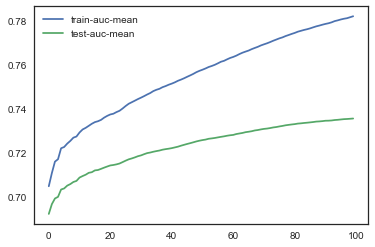

In [146]:
dtrain = xgb.DMatrix(train[features].as_matrix(), label=train[target].as_matrix())
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'nthread': 4,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'silent': 1
}
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=100, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[["train-auc-mean", "test-auc-mean"]].plot()

[0]	train-auc:0.687618	test-auc:0.672504
[50]	train-auc:0.779405	test-auc:0.731865
[99]	train-auc:0.805998	test-auc:0.739809


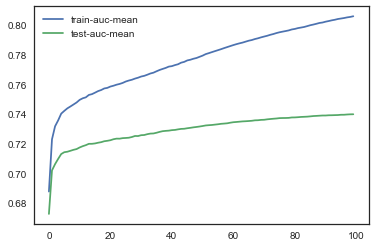

In [162]:
dtrain = xgb.DMatrix(train[features].as_matrix(), label=train[target].as_matrix())
xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'nthread': 8,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'silent': 1
}
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=100, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[["train-auc-mean", "test-auc-mean"]].plot()

In [181]:
# another set of params with slight tweak
dtrain = xgb.DMatrix(train[features].as_matrix(), label=train[target].as_matrix())
xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'nthread': 8,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'silent': 1
}
best = xgb.train(xgb_params, dtrain, 100, [(dtrain, 'train')], verbose_eval=50, early_stopping_rounds=20)

[0]	train-auc:0.681965
Will train until train-auc hasn't improved in 20 rounds.
[50]	train-auc:0.769285
[99]	train-auc:0.790955


In [ ]:
# make sure column ordering is consistent
test_features = test[features].reindex(columns=train[features].columns.tolist())
dtest = xgb.DMatrix(test_features.as_matrix())
test_predictions = best.predict(dtest, ntree_limit=best.best_ntree_limit)

test = pd.read_csv('test.csv')
output_df = pd.DataFrame({'RefId': test['RefId'].as_matrix(), 'IsBadBuy': test_predictions})
output_df.to_csv('test_y_xgb.csv', index=False)

# Interpret our best model

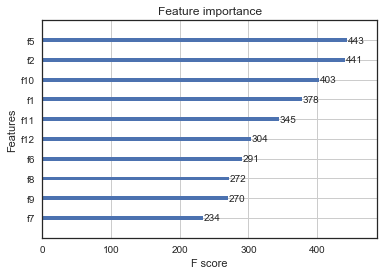

In [208]:
xgb.plot_importance(best, max_num_features=10)

In [236]:
# feature mapping
feature_dict = {a: b for a, b in zip(dtrain.feature_names, features)}
[(feature_dict[feature], score) for feature, score in \
     sorted(list(best.get_fscore().items()),key=lambda x: x[1])[-10:][::-1]]

[('MMRCurrentAuctionAveragePrice_DepPerYear', 443),
 ('VehBCost', 441),
 ('MMRCurrentAuctionCleanPrice_DepPerYear', 403),
 ('VehOdo', 378),
 ('MMRCurrentRetailAveragePrice_DepPerYear', 345),
 ('MMRCurrentRetailCleanPrice_DepPerYear', 304),
 ('MMRAcquisitionAuctionAveragePrice_diff', 291),
 ('MMRAcquisitionRetailAveragePrice_diff', 272),
 ('MMRAcquisitionRetailCleanPrice_diff', 270),
 ('MMRAcquisitionAuctionCleanPrice_diff', 234)]

# Future Work

- Overlay income and consumer price data using zipcode to get a better idea of pricing
- Perform grid Search for Logistic, Naive Bayes and Random Forest, default parameter is unlikely to be the best
- XGBoost proves to be powerful here (even without much parameter tuning). The current best model overfits. I'd like to tune parameters in that direction.
- Stratify training data, given only around 10% was a bad buy
- dig deeper into Current Prices and Acquisition Prices. Currently, current prices are turned into a depreciation per year. Is this the best way to use these prices? They are also probably correlated.
- there are over 2000 columns after we convert categories into dummies. it's too sparse, meaning we would want to drop some of the less frequent columns to prevent overfitting in our model.